In [1]:
import pandas as pd
from tokenize_dataset import tokenize_dataset
from isolation_forest import isolation_forest

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Set target variable

In [2]:
target = 'Neoadjuvant Endocrine Therapy Medications '

In [3]:
df = pd.read_csv("Clinical and Other Features.csv", low_memory=False)

In [4]:
clinical_ids = df[list(df.columns)[0]]

Set patient IDs as the index of df

In [5]:
df = df.set_index(str(list(df.columns)[0]))

In [6]:
df = tokenize_dataset(df)

Partition data

In [7]:
x = df.drop(target, axis=1)
y = df[target]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=84)

X_test, X_val = train_test_split(X_test, test_size=0.5, random_state=84)
y_test, y_val = train_test_split(y_test, test_size=0.5, random_state=84)

Normalize Data

In [9]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.fit_transform(X_test)
X_val = min_max_scaler.fit_transform(X_val)

Use Isolation Forest to detect and remove outliers

isolation forest starting
isolation foreset ending
Num Outliers: 97


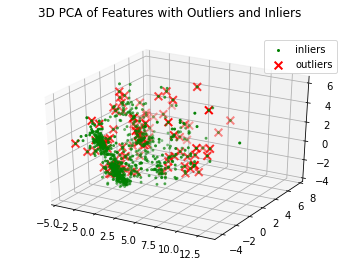

In [10]:
predicted = isolation_forest(X_train, y_train)
non_outlier_indices = []
i = 0
for prediction in predicted:
  if prediction != -1:
    non_outlier_indices.append(i)
  i = i + 1

num_outliers = len(predicted) - len(non_outlier_indices)
print("Num Outliers:", num_outliers)

X_train = X_train[non_outlier_indices]
y_train = y_train.iloc[non_outlier_indices]

Define model

In [11]:
import torch.nn as nn

class duke_model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(74, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, num_classes)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)

        return x

In [12]:
num_classes = len(list(set(y_train)))
model = duke_model(num_classes)

In [13]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def train_model(config, data, epochs=10, batch_size=32):
  X_train = data[0]
  y_train = data[1]
  X_val = data[2]
  y_val = data[3]
  y_train = y_train.to_numpy()
  y_val = y_val.to_numpy()
  X_val = torch.from_numpy(X_val).type(torch.float)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(epochs):
    running_loss = 0.0
    for i in range((X_train.shape[0]-1)//batch_size + 1):
      start_i = i*batch_size
      end_i = start_i+batch_size
      xb = torch.from_numpy(X_train[start_i:end_i]).type(torch.float)
      yb = torch.from_numpy(y_train[start_i:end_i])
      
      pred = model(xb)
      loss = criterion(pred, yb)

      loss.backward()
      optimizer.step()

      # zero the parameter gradients
      optimizer.zero_grad()

      running_loss += loss.item()
      pred = model(X_val).detach().numpy().astype(np.float)
      pred = np.argmax(pred, axis=1)
      accuracy = accuracy_score(y_val, pred)
      f1 = f1_score(y_val, pred, average='micro')
      print('Completed training batch', epoch, 'Training Loss is: %.4f' %running_loss, 'Accuracy: %.4f' %accuracy, 'F1: %.4f' %f1)
      tune.report(loss=running_loss, accuracy=accuracy)
      running_loss = 0.0

  return model

Use Raytune to determine hyperparameters

In [14]:
import ray
from ray import tune
from ray.tune.schedulers.async_hyperband import ASHAScheduler

config = {
    'epochs':tune.choice([50, 100, 150]),
    'batch_size':tune.choice([8, 16, 32, 64]),
    'lr':tune.loguniform(1e-3, 1e-1),
}
scheduler = ASHAScheduler(
    max_t=10,
    grace_period=1,
    reduction_factor=3
)
result = tune.run(
    tune.with_parameters(train_model, data=[X_train, y_train, X_val, y_val]),
    resources_per_trial={"cpu":2},
    config=config,
    metric="loss",
    mode="min",
    num_samples=10,
    scheduler=scheduler
)
best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["loss"]))
print("Best trial final validation accuracy: {}".format(
    best_trial.last_result['accuracy']))

2022-06-29 22:23:04,737	WARNING function_runner.py:604 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-06-29 22:23:04,796	INFO logger.py:630 -- pip install "ray[tune]" to see TensorBoard files.
2022-06-29 22:23:04,800	WARNING callback.py:106 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,batch_size,epochs,lr
train_model_0b783_00000,RUNNING,172.28.0.2:7483,64,50,0.00109587
train_model_0b783_00001,PENDING,,64,50,0.0192517
train_model_0b783_00002,PENDING,,8,100,0.0628104
train_model_0b783_00003,PENDING,,8,100,0.00135114
train_model_0b783_00004,PENDING,,16,50,0.0104955
train_model_0b783_00005,PENDING,,16,150,0.0771303
train_model_0b783_00006,PENDING,,32,150,0.0101384
train_model_0b783_00007,PENDING,,32,100,0.0773647
train_model_0b783_00008,PENDING,,16,150,0.0998661
train_model_0b783_00009,PENDING,,64,150,0.00127425


(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:12: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
(train_model pid=7483)   import ray._private.utils
(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://n

Result for train_model_0b783_00000:
  accuracy: 0.021505376344086023
  date: 2022-06-29_22-23-08
  done: false
  experiment_id: d88c02135d784612b885a4344a41e827
  hostname: 1b97b3628bd2
  iterations_since_restore: 1
  loss: 1.1921055316925049
  node_ip: 172.28.0.2
  pid: 7483
  time_since_restore: 0.07240438461303711
  time_this_iter_s: 0.07240438461303711
  time_total_s: 0.07240438461303711
  timestamp: 1656541388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0b783_00000
  warmup_time: 0.0042612552642822266
  
Result for train_model_0b783_00000:
  accuracy: 0.5806451612903226
  date: 2022-06-29_22-23-08
  done: true
  experiment_id: d88c02135d784612b885a4344a41e827
  hostname: 1b97b3628bd2
  iterations_since_restore: 10
  loss: 1.0681240558624268
  node_ip: 172.28.0.2
  pid: 7483
  time_since_restore: 0.13269925117492676
  time_this_iter_s: 0.0059583187103271484
  time_total_s: 0.13269925117492676
  timestamp: 1656541388
  timesteps_since_restore: 0
  training_itera

(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=7483)   )
(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Result for train_model_0b783_00002:
  accuracy: 0.956989247311828
  date: 2022-06-29_22-23-08
  done: false
  experiment_id: d88c02135d784612b885a4344a41e827
  hostname: 1b97b3628bd2
  iterations_since_restore: 1
  loss: 0.8710176348686218
  node_ip: 172.28.0.2
  pid: 7483
  time_since_restore: 0.013704538345336914
  time_this_iter_s: 0.013704538345336914
  time_total_s: 0.013704538345336914
  timestamp: 1656541388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0b783_00002
  warmup_time: 0.0042612552642822266
  
Result for train_model_0b783_00002:(train_model pid=7483) Completed training batch 0 Training Loss is: 0.9136 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.8710 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.8562 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.8385 Accuracy: 0.9570 F1: 0.9570
(train_model pid=

(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=7483)   )
(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Result for train_model_0b783_00004:
  accuracy: 0.956989247311828
  date: 2022-06-29_22-23-08
  done: false
  experiment_id: d88c02135d784612b885a4344a41e827
  hostname: 1b97b3628bd2
  iterations_since_restore: 1
  loss: 0.30283665657043457
  node_ip: 172.28.0.2
  pid: 7483
  time_since_restore: 0.011378288269042969
  time_this_iter_s: 0.011378288269042969
  time_total_s: 0.011378288269042969
  timestamp: 1656541388
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0b783_00004
  warmup_time: 0.0042612552642822266
  
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.4408 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.3028 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.2838 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.2574 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 T

(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=7483)   )
(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Result for train_model_0b783_00005:
  accuracy: 0.956989247311828
  date: 2022-06-29_22-23-09
  done: true
  experiment_id: d88c02135d784612b885a4344a41e827
  hostname: 1b97b3628bd2
  iterations_since_restore: 10
  loss: 0.2996014952659607
  node_ip: 172.28.0.2
  pid: 7483
  time_since_restore: 0.12213468551635742
  time_this_iter_s: 0.00811147689819336
  time_total_s: 0.12213468551635742
  timestamp: 1656541389
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0b783_00005
  warmup_time: 0.0042612552642822266
  
Result for train_model_0b783_00006:
  accuracy: 0.956989247311828
  date: 2022-06-29_22-23-09
  done: false
  experiment_id: d88c02135d784612b885a4344a41e827
  hostname: 1b97b3628bd2
  iterations_since_restore: 1
  loss: 0.03523273766040802
  node_ip: 172.28.0.2
  pid: 7483
  time_since_restore: 0.011791706085205078
  time_this_iter_s: 0.011791706085205078
  time_total_s: 0.011791706085205078
  timestamp: 1656541389
  timesteps_since_restore: 0
  training_iterat

(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=7483)   )
(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Result for train_model_0b783_00007:
  accuracy: 0.956989247311828
  date: 2022-06-29_22-23-09
  done: true
  experiment_id: d88c02135d784612b885a4344a41e827
  hostname: 1b97b3628bd2
  iterations_since_restore: 10
  loss: 0.31834572553634644
  node_ip: 172.28.0.2
  pid: 7483
  time_since_restore: 0.11006641387939453
  time_this_iter_s: 0.006924629211425781
  time_total_s: 0.11006641387939453
  timestamp: 1656541389
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: 0b783_00007
  warmup_time: 0.0042612552642822266
  
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.0262 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.0201 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.3691 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Training Loss is: 0.5061 Accuracy: 0.9570 F1: 0.9570
(train_model pid=7483) Completed training batch 0 Tr

(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
(train_model pid=7483)   )
(train_model pid=7483) /usr/local/lib/python3.7/dist-packages/ray/workers/default_worker.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
(train_model pid=7483) Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#

Trial name,status,loc,batch_size,epochs,lr,iter,total time (s),loss,accuracy
train_model_0b783_00000,TERMINATED,172.28.0.2:7483,64,50,0.00109587,10,0.132699,1.06812,0.580645
train_model_0b783_00001,TERMINATED,172.28.0.2:7483,64,50,0.0192517,10,0.10982,0.913592,0.956989
train_model_0b783_00002,TERMINATED,172.28.0.2:7483,8,100,0.0628104,10,0.0966125,0.700311,0.956989
train_model_0b783_00003,TERMINATED,172.28.0.2:7483,8,100,0.00135114,10,0.0776088,0.440774,0.956989
train_model_0b783_00004,TERMINATED,172.28.0.2:7483,16,50,0.0104955,10,0.122163,0.294442,0.956989
train_model_0b783_00005,TERMINATED,172.28.0.2:7483,16,150,0.0771303,10,0.122135,0.299601,0.956989
train_model_0b783_00006,TERMINATED,172.28.0.2:7483,32,150,0.0101384,10,0.0815158,0.312643,0.956989
train_model_0b783_00007,TERMINATED,172.28.0.2:7483,32,100,0.0773647,10,0.110066,0.318346,0.956989
train_model_0b783_00008,TERMINATED,172.28.0.2:7483,16,150,0.0998661,10,0.0894251,0.321607,0.956989
train_model_0b783_00009,TERMINATED,172.28.0.2:7483,64,150,0.00127425,9,0.0879822,0.164029,0.956989


2022-06-29 22:23:09,780	INFO tune.py:748 -- Total run time: 5.05 seconds (4.68 seconds for the tuning loop).


Best trial config: {'epochs': 150, 'batch_size': 64, 'lr': 0.0012742530598413872}
Best trial final validation loss: 0.16402886807918549
Best trial final validation accuracy: 0.956989247311828


In [15]:
train_model(config=best_trial, data=[X_train, y_train, X_val, y_val])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 0 Training Loss is: 1.1921 Accuracy: 0.0215 F1: 0.0215


2022-06-29 22:23:10,360	WARNING session.py:35 -- Session not detected. You should not be calling `report` outside `tune.run` or while using the class API. 
2022-06-29 22:23:10,362	WARNING session.py:38 --   File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib

Completed training batch 0 Training Loss is: 1.1780 Accuracy: 0.0215 F1: 0.0215
Completed training batch 0 Training Loss is: 1.1665 Accuracy: 0.0215 F1: 0.0215
Completed training batch 0 Training Loss is: 1.1432 Accuracy: 0.0215 F1: 0.0215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 1.1355 Accuracy: 0.0215 F1: 0.0215
Completed training batch 0 Training Loss is: 1.1237 Accuracy: 0.0215 F1: 0.0215
Completed training batch 0 Training Loss is: 1.1081 Accuracy: 0.0215 F1: 0.0215


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 1.0929 Accuracy: 0.1183 F1: 0.1183
Completed training batch 0 Training Loss is: 1.0763 Accuracy: 0.2903 F1: 0.2903
Completed training batch 0 Training Loss is: 1.0681 Accuracy: 0.5806 F1: 0.5806


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 1.0593 Accuracy: 0.8172 F1: 0.8172
Completed training batch 0 Training Loss is: 1.0433 Accuracy: 0.9462 F1: 0.9462
Completed training batch 0 Training Loss is: 1.0246 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 1.0065 Accuracy: 0.9570 F1: 0.9570
Completed training batch 0 Training Loss is: 0.9827 Accuracy: 0.9570 F1: 0.9570
Completed training batch 0 Training Loss is: 0.9744 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.9540 Accuracy: 0.9570 F1: 0.9570
Completed training batch 0 Training Loss is: 0.9549 Accuracy: 0.9570 F1: 0.9570
Completed training batch 0 Training Loss is: 0.9257 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 0 Training Loss is: 0.9114 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.8703 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.8546 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.8351 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.8398 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.8519 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.7943 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.7328 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.7153 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.6767 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.6803 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.6455 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.6083 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.5597 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.5150 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.4486 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.4607 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.4145 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.5315 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 1 Training Loss is: 0.3813 Accuracy: 0.9570 F1: 0.9570
Completed training batch 1 Training Loss is: 0.3944 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.2290 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.2092 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.1835 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.3330 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.4204 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.3355 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.1038 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.1810 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.1640 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.2882 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.1955 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.1829 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.1925 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.1547 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.0344 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.1483 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.1850 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.6197 Accuracy: 0.9570 F1: 0.9570
Completed training batch 2 Training Loss is: 0.2118 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 2 Training Loss is: 0.3425 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.0214 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.0240 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.0227 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.3500 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.4827 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.3881 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.0234 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.1635 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.1516 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.3142 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.1903 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.1758 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.1920 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.1513 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 3 Training Loss is: 0.0279 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.1471 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 3 Training Loss is: 0.1817 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.5861 Accuracy: 0.9570 F1: 0.9570
Completed training batch 3 Training Loss is: 0.2007 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 3 Training Loss is: 0.3085 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.0328 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.0378 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.0386 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 4 Training Loss is: 0.3138 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.4260 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 4 Training Loss is: 0.3397 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.0444 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 4 Training Loss is: 0.1604 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.1470 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 4 Training Loss is: 0.2818 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.1834 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 4 Training Loss is: 0.1723 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.1803 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 4 Training Loss is: 0.1489 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.0469 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Completed training batch 4 Training Loss is: 0.1512 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.1766 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 4 Training Loss is: 0.5275 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.1941 Accuracy: 0.9570 F1: 0.9570
Completed training batch 4 Training Loss is: 0.2825 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0459 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.0499 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.0498 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.3006 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.4032 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.3220 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.0505 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.1609 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.1456 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.2737 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.1783 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.1682 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1731 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.1442 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.0438 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1494 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.1751 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.5279 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 5 Training Loss is: 0.1892 Accuracy: 0.9570 F1: 0.9570
Completed training batch 5 Training Loss is: 0.2738 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.0407 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.0439 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.0440 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.2990 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.3967 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.3150 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.0451 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1596 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.1425 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.2692 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1713 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.1632 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.1652 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1387 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.0402 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.1481 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.1739 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.5239 Accuracy: 0.9570 F1: 0.9570
Completed training batch 6 Training Loss is: 0.1848 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 6 Training Loss is: 0.2632 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.0390 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.0421 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0426 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.2944 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.3844 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.3028 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.0447 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.1594 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.1406 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.2619 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.1649 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.1594 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.1570 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.1339 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.0398 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.1477 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.1725 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 7 Training Loss is: 0.5137 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.1804 Accuracy: 0.9570 F1: 0.9570
Completed training batch 7 Training Loss is: 0.2513 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0388 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.0415 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.0422 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.2891 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.3706 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.2897 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.0444 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.1592 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.1387 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.2546 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.1578 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.1556 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1483 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.1286 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.0387 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1471 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.1712 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.5050 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 8 Training Loss is: 0.1757 Accuracy: 0.9570 F1: 0.9570
Completed training batch 8 Training Loss is: 0.2399 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.0378 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.0400 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.0408 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.2841 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.3570 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.2764 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.0435 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1589 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.1369 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.2477 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1500 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.1517 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.1390 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1228 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.0376 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.1468 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for 

Completed training batch 9 Training Loss is: 0.1702 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.4953 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.1709 Accuracy: 0.9570 F1: 0.9570
Completed training batch 9 Training Loss is: 0.2276 Accuracy: 0.9570 F1: 0.9570


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


duke_model(
  (relu): ReLU()
  (fc1): Linear(in_features=74, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=3, bias=True)
)